### IMPORTING LIBRARIES

In [1]:
import mediapipe as mp
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import math

### GET THE CENTROID VALUES

In [2]:
def retrieve_centroid_values(video_path):
    cap = cv2.VideoCapture(video_path)
    holistic_model = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    rvx_centroid = []
    rvy_centroid = []
    lvx_centroid = []
    lvy_centroid = []
    while True:
        ret, frame = cap.read()
        num_of_frames = int(cap. get(cv2. CAP_PROP_FRAME_COUNT))
        if ret == True:
            converttoRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic_model.process(converttoRGB)
            height, width, _ = frame.shape
            rfx_centroid = []
            rfy_centroid = []
            lfx_centroid = []
            lfy_centroid = []
            rh_c=[16, 18, 20, 22]
            lh_c=[15, 17, 21, 19]
            # find centroid for right and left palm for each frame
            for i in rh_c:
                rfy_centroid.append(results.pose_landmarks.landmark[i].y * height)
                rfx_centroid.append(results.pose_landmarks.landmark[i].x * width)
            for i in lh_c:
                lfy_centroid.append(results.pose_landmarks.landmark[i].y * height)
                lfx_centroid.append(results.pose_landmarks.landmark[i].x * width)
            # take mean of the centroid values for both palms for that frame and append 
            #to the array that holds centroid values for each frame in the video
            rvx_centroid.append(np.mean(rfx_centroid))
            rvy_centroid.append(np.mean(rfy_centroid))
            lvx_centroid.append(np.mean(lfx_centroid))
            lvy_centroid.append(np.mean(lfy_centroid))
        else:
            break
    return rvx_centroid, rvy_centroid, lvx_centroid, lvy_centroid, num_of_frames

### FUNCTION FOR CALCULATING EUCLIDEAN DISTANCE BETWEEN TWO POINTS

In [3]:
def euclidian_distance(x2, x1, y2, y1):
    return (math.sqrt(math.pow(x2 - x1, 2) +math.pow(y2 - y1, 2) ))

### FINDING HAND DISTANCE AND HAND HEIGHT

In [4]:
def find_hand_distance_hand_height(lh_x, lh_y, rh_x, rh_y, f_no):
    hand_dist=[]
    hand_height=np.minimum(lh_y, rh_y) # 
    for i in range(0, f_no-1):
        rh= euclidian_distance(rh_x[i+1], rh_x[i], rh_y[i+1], rh_y[i])
        lh=euclidian_distance(lh_x[i+1], lh_x[i], lh_x[i+1], lh_x[i]) 
                    #using current frame and next frame
        hand_dist.append(max(lh, rh)) 
    return hand_dist, hand_height

### PLOTTING HAND DISTANCE AND HEIGHT VALUES AGAINST NUMBER OF FRAMES

In [5]:
def plot_func(hand_dist, hand_height, f_no, filename):
    plt.figure(figsize=(6, 3))
    plt.scatter([i for i in range(0, f_no-1)], hand_dist)
    a=np.mean(hand_dist) # threshold value for hand distance is taken as the mean of all the hand distance values
    plt.plot([0, f_no], [a, a], color="red")
    plt.ylabel("Hand Distance")
    plt.xlabel("Number of Frames for "+filename)
    plt.show()
    plt.figure(figsize=(6, 3))
    plt.scatter([i for i in range(0, f_no)], hand_height)
    b=np.mean(hand_height)
    plt.plot([0, f_no], [b, b], color="red")
    plt.ylabel("Hand Height")
    plt.xlabel("Number of Frames for "+filename)
    plt.show()
    return a,b

### Create an output file that excludes frames not in line with the threshold values

In [12]:
def KFS_output(video_path, save_dir, h_dist, h_height):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
    ret, frame = cap.read()
    height, width, _ = frame.shape
    fps = cap.get(cv2.CAP_PROP_FPS)
    output = cv2.VideoWriter( save_dir,fourcc, fps, (width,height))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        for f, j in zip(h_dist, h_height):
            if f>a:
                output.write(frame)
            elif(j<b):
                output.write(frame)
    num_of_frames = int(output. get(cv2. CAP_PROP_FRAME_COUNT))
    output.release()
    return num_of_frames

### Create Summary report and graphs of each sample video

In [25]:
import codecs, json


['sample1.mp4', 'sample2.mp4', 'sample3.mp4', 'sample4.mp4', 'sample5.mp4', 'sample6.mp4']


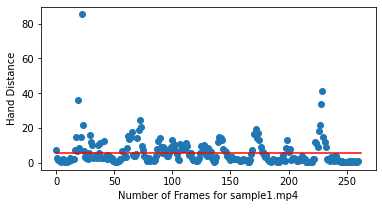

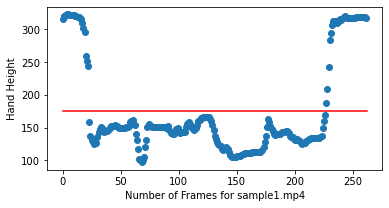

TypeError: Object of type StreamReaderWriter is not JSON serializable

In [26]:
# obtains path for save directory and path for sample videos
save_dir="../../KT_Session_2/Output/"
videos_path="../../KT_Session_2/sample_videos/"
video_path_list = os.listdir(videos_path)
print(video_path_list)
for v_name in video_path_list:
    video_path = os.path.join(videos_path, v_name)
    video = cv2.VideoCapture(video_path)
    # gets centroid values for right and left palm
    rvx_centroid, rvy_centroid, lvx_centroid, lvy_centroid, num_of_frames=retrieve_centroid_values(video_path)
    # find hand distance and hand height using the centroids
    h_dist, h_height=find_hand_distance_hand_height(lvx_centroid, lvy_centroid, rvx_centroid, rvy_centroid, num_of_frames)
    # finds threshold value for hand distance and hand height
    a,b=plot_func(h_dist, h_height, num_of_frames, v_name)
    # path for created output video file
    output_path = os.path.join(save_dir, v_name.split(".")[0], v_name.split(".")[0] + "_output.mp4")
#     o_frame_num=KFS_output(video_path, output_path, h_dist, h_height)
    # Removes unwanted frames using the a and b values used to threshold hand distance and hand height and saves frames to an output file
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
    ret, frame = cap.read()
    height, width, _ = frame.shape
    fps = cap.get(cv2.CAP_PROP_FPS)
    output = cv2.VideoWriter( save_dir,fourcc, fps, (width,height))
    i=0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if(h_dist[i-1]>a and i!=0):
            output.write(frame)
        elif(h_height[i]<b):
            output.write(frame)
        i+=1
    o_frame_num = int(output. get(cv2. CAP_PROP_FRAME_COUNT))
    # creates a summary report of all the values
    output.release()
    summary_report = {}
    summary_report["Filename"] = v_name
    summary_report["Hand_Height"] = h_height
    summary_report["Hand_Distance"] = h_dist
    summary_report["Initial_Frame_Count"] = num_of_frames
    summary_report["Post_KFS_Frame_Count"] = o_frame_num
    summary_report["Percentage_Reduction"] = round(((num_of_frames-o_frame_num)/num_of_frames)*100, 2)
    summary_report["Hand_Height_Threshold_Value"] = a
    summary_report["Hand_Distance_Threshold_Value"] = b
    summary_report_path = os.path.join(save_dir, v_name.split(".")[0] + "_output.json")
    with open(summary_report_path, "w") as s:
        s.write(json.dumps(codecs.open(summary_report_path, 'w', encoding='utf-8')))


According to the graphs we can see that the max values which are far beyond the threshold are at the start and end of the video which corrosponds to the starting position assumed by the signers which is both the hands down. The threshold seeks to remove the starting position and subsequent pauses observed during the video in order to obtain a video with less number of frames.

In [ ]:
save_dir="../../KT_Session_2/Output/"
v_1="../../KT_Session_2/sample_videos/sample1.mp4"
v_2="../../KT_Session_2/sample_videos/sample2.mp4"
v_3="../../KT_Session_2/sample_videos/sample3.mp4"
v_4="../../KT_Session_2/sample_videos/sample4.mp4"
v_5="../../KT_Session_2/sample_videos/sample5.mp4"
v_6="../../KT_Session_2/sample_videos/sample6.mp4"

vid_1 = cv2.VideoCapture(v_1)
# gets centroid values for right and left palm
rvx_centroid1, rvy_centroid1, lvx_centroid1, lvy_centroid1, num_of_frames1=retrieve_centroid_values(vid_1)
# find hand distance and hand height using the centroids
h_dist1, h_height1=find_hand_distance_hand_height(lvx_centroid1, lvy_centroid1, rvx_centroid1, rvy_centroid1, num_of_frames1)
# finds threshold value for hand distance and hand height
a1,b1=plot_func(h_dist, h_height, num_of_frames, v_name)

vid_2 = cv2.VideoCapture(v_2)
vid_3 = cv2.VideoCapture(v_3)
vid_4 = cv2.VideoCapture(v_4)
vid_5 = cv2.VideoCapture(v_5)
vid_6 = cv2.VideoCapture(v_6)

